In [197]:
library(effsize)
library(dplyr)
library(ggplot2)
library(corrplot)
library(stargazer)
library(MASS)

In [198]:
# Imports Data
dfCrime = read.csv("crime_v2.csv")

In [199]:
# summary(dfCrime)

In [200]:
#unique(dfCrime$prbconv)

In [201]:
# dfCrime[is.na(dfCrime),]
# dfCrime
nrow(dfCrime)

[1] 97

In [202]:
dfCrime <-na.omit(dfCrime) # get rid of the NA rows
nrow(dfCrime)

[1] 91

In [203]:
dfCrime[duplicated(dfCrime),]
# unique(dfCrime$county)

,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,⋯,wtuc,wtrd,wfir,wser,wmfg,wfed,wsta,wloc,mix,pctymle
89,193,87,0.0235277,0.266055,0.588859022,0.423423,5.86,0.00117887,0.8138298,28.51783,⋯,480.1948,268.3836,365.0196,295.9352,295.63,468.26,337.88,348.74,0.1105016,0.07819394


In [204]:
dfCrime <- dfCrime[!duplicated(dfCrime),] # get rid of the duplicated row
nrow(dfCrime)

[1] 90

In [205]:
dfCrime$prbconv<-as.numeric(levels(dfCrime$prbconv))[dfCrime$prbconv]
#dfCrime$prbconv<-as.double(dfCrime$prbconv)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [206]:
#dfCrime$county<-as.factor(dfCrime$county) #note that we're missing 10 counties from NC; 6 were blank rows in this set, one row was a duplicate

In [207]:
dfCrime$pctmin80<-dfCrime$pctmin80/100 # units are off in comparison to pctymle; we either divide by 100 here or multiply the other one

In [208]:
#Map central and west to a region code.
# Note that county 71 has both western and central codes
dfCrime$region <- case_when (
            (dfCrime$central ==0 & dfCrime$west ==0) ~ 0, #Eastern, Coastal, Other
            (dfCrime$central ==0 & dfCrime$west ==1) ~ 1, #Western
            (dfCrime$central ==1 & dfCrime$west ==0) ~ 2, #Central
            (dfCrime$central ==1 & dfCrime$west ==1) ~ 3, #Central-Western border county - this could be Charlotte or it could be a coding error.
        )

In [209]:
# create a factor for 'central', 'western', 'central/western' and 'eastern, coastal, other' region
#dfCrime$region =
#             factor( dfCrime$region , levels = 0:3 , labels =
#                     c( 'Region 1',
#                        'Region 2',
#                        'Region 3',
#                        'Region 4'
#                       )
#                    )

In [210]:
# create factor for SMSA (standard metropolitan statistical areas) with two levels - inside or outside
#    https://www2.census.gov/prod2/decennial/documents/1980/1980censusofpopu8011uns_bw.pdf
dfCrime$metro =
            factor( dfCrime$urban , levels = 0:1 , labels =
                    c( 'Outside',
                       'Inside'
                      )
                   )

In [211]:
dfCrime$wser[which(dfCrime$county==185)]<- median(dfCrime$wser)
dfCrime$wser[which(dfCrime$county==185)]

[1] 253.1188

In [213]:
#transform our variables

dfCrime$lpolpc <-log10(dfCrime$polpc)
dfCrime$lprbpris <- log10(dfCrime$prbpris)
dfCrime$lpctymle <- log10(dfCrime$pctymle)
dfCrime$lavgsen <- log10(dfCrime$avgsen)
dfCrime$ldensity <- log10(dfCrime$density)
dfCrime$ltaxpc <- log10(dfCrime$taxpc)
dfCrime$lmix <- log10(dfCrime$mix)
dfCrime$lpctmin80 <- log10(dfCrime$pctmin80)

dfCrime$lcrmrte = log10(dfCrime$crmrte)
dfCrime$lprbconv = log10(dfCrime$prbconv)
dfCrime$lprbarr = log10(dfCrime$prbarr)
dfCrime$lwcon<-log10(dfCrime$wcon)
dfCrime$lwtrd<-log10(dfCrime$wtrd)
dfCrime$lwfir<-log10(dfCrime$wfir)
dfCrime$lwser<-log10(dfCrime$wser)
dfCrime$lwmfg<-log10(dfCrime$wmfg)
dfCrime$lwfed<-log10(dfCrime$wfed)
dfCrime$lwsta<-log10(dfCrime$wsta)
dfCrime$lwloc<-log10(dfCrime$wloc)

In [214]:
#create a geography index factor based on density and percent minority,  young male and region

dfCrime$geoidx<-as.factor(round(log10(dfCrime$density) + dfCrime$pctymle + dfCrime$pctmin80 + dfCrime$region, digits=1))

In [218]:
# dfCrime %>% arrange(desc(geoidx))

In [216]:
#create a wage index and a probability of police encounter index

dfCrime$wgidx <- dfCrime$lwcon + dfCrime$lwtrd + dfCrime$lwfir + dfCrime$lwser + dfCrime$lwmfg + dfCrime$lwfed + dfCrime$lwsta + dfCrime$lwloc 

dfCrime$plidx <- log10(dfCrime$prbarr * dfCrime$prbconv)

In [223]:
mod2 <- lm(crmrte ~ geoidx + wgidx + plidx, data = dfCrime)
mod2

summary(mod2)



Call:
lm(formula = crmrte ~ geoidx + wgidx + plidx, data = dfCrime)

Coefficients:
(Intercept)   geoidx-0.2   geoidx-0.1      geoidx0    geoidx0.1    geoidx0.2  
 -0.1567212    0.0447850    0.0026583   -0.0009477    0.0087603    0.0095009  
  geoidx0.3    geoidx0.4    geoidx0.5    geoidx0.6    geoidx0.7    geoidx0.8  
  0.0097414    0.0127857    0.0188229    0.0123168    0.0177272   -0.0062599  
  geoidx0.9      geoidx1    geoidx1.1    geoidx1.2    geoidx1.3    geoidx1.4  
 -0.0075956   -0.0005851    0.0340720    0.0022172    0.0068682    0.0028945  
  geoidx1.6      geoidx2    geoidx2.1    geoidx2.2    geoidx2.3    geoidx2.4  
  0.0114381    0.0070829   -0.0012655    0.0024048    0.0060753    0.0045903  
  geoidx2.5    geoidx2.6    geoidx2.7      geoidx3    geoidx3.1    geoidx3.2  
  0.0145975    0.0078045    0.0263554    0.0201410    0.0256400    0.0305602  
  geoidx3.3    geoidx3.9        wgidx        plidx  
  0.0559585    0.0184015    0.0076894   -0.0298097  



Call:
lm(formula = crmrte ~ geoidx + wgidx + plidx, data = dfCrime)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.033618 -0.004255  0.000000  0.004375  0.018517 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.1567212  0.0981298  -1.597  0.11588    
geoidx-0.2   0.0447850  0.0155623   2.878  0.00566 ** 
geoidx-0.1   0.0026583  0.0151383   0.176  0.86124    
geoidx0     -0.0009477  0.0125364  -0.076  0.94001    
geoidx0.1    0.0087603  0.0120258   0.728  0.46937    
geoidx0.2    0.0095009  0.0121034   0.785  0.43577    
geoidx0.3    0.0097414  0.0120587   0.808  0.42261    
geoidx0.4    0.0127857  0.0134379   0.951  0.34546    
geoidx0.5    0.0188229  0.0119578   1.574  0.12110    
geoidx0.6    0.0123168  0.0134939   0.913  0.36528    
geoidx0.7    0.0177272  0.0117714   1.506  0.13770    
geoidx0.8   -0.0062599  0.0124231  -0.504  0.61631    
geoidx0.9   -0.0075956  0.0132183  -0.575  0.56784    
geoidx1     -0.0005851  0.012110

In [222]:
mod3 <- lm(crmrte ~ geoidx * ( wgidx + plidx), data = dfCrime)
mod3

summary(mod3)


Call:
lm(formula = crmrte ~ geoidx * (wgidx + plidx), data = dfCrime)

Coefficients:
     (Intercept)        geoidx-0.2        geoidx-0.1           geoidx0  
      -0.0804947         0.0256716         0.0059788         2.0291939  
       geoidx0.1         geoidx0.2         geoidx0.3         geoidx0.4  
      -0.0309486         0.0503274        -1.7817866         1.5560038  
       geoidx0.5         geoidx0.6         geoidx0.7         geoidx0.8  
       0.1988769        -0.3764389        -0.3892855         0.2051321  
       geoidx0.9           geoidx1         geoidx1.1         geoidx1.2  
      -6.6720860        -0.2025711        -1.2350986        -0.0009710  
       geoidx1.3         geoidx1.4         geoidx1.6           geoidx2  
       0.6472370         0.0004612         0.0041874         0.0018409  
       geoidx2.1         geoidx2.2         geoidx2.3         geoidx2.4  
       1.0739868        -0.3606538         0.7358592        -0.6715809  
       geoidx2.5         geoidx2.6    


Call:
lm(formula = crmrte ~ geoidx * (wgidx + plidx), data = dfCrime)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.018625 -0.001197  0.000000  0.000000  0.015948 

Coefficients: (26 not defined because of singularities)
                   Estimate Std. Error t value Pr(>|t|)   
(Intercept)      -0.0804947  0.2006834  -0.401  0.69260   
geoidx-0.2        0.0256716  0.0185091   1.387  0.18072   
geoidx-0.1        0.0059788  0.0125922   0.475  0.64007   
geoidx0           2.0291939  7.5147527   0.270  0.78991   
geoidx0.1        -0.0309486  1.1908699  -0.026  0.97952   
geoidx0.2         0.0503274  0.4461084   0.113  0.91130   
geoidx0.3        -1.7817866  1.0006967  -1.781  0.09018 . 
geoidx0.4         1.5560038  2.7921254   0.557  0.58352   
geoidx0.5         0.1988769  0.3334243   0.596  0.55755   
geoidx0.6        -0.3764389  1.0374688  -0.363  0.72053   
geoidx0.7        -0.3892855  0.2830063  -1.376  0.18418   
geoidx0.8         0.2051321  0.9176484   0.224  0.

In [225]:
library(broom)

In [227]:
mod3_aug<-mod3 %>%augment

In [230]:
mod3_aug

.rownames,crmrte,geoidx,wgidx,plidx,.fitted,.se.fit,.resid,.hat,.sigma,.cooksd,.std.resid
1,0.0356036,2.7,20.05162,-0.8030890,0.03560360,0.008696168,-1.759538e-16,1.0000000,0.008922080,NaN,NaN
2,0.0152532,2.2,19.52494,-0.7086349,0.01713797,0.006742917,-1.884771e-03,0.6012289,0.008895766,0.0025372069,-0.3432171
3,0.0129603,0.7,19.42441,-0.9242800,0.03158574,0.005365587,-1.862544e-02,0.3806963,0.007079660,0.0650474967,-2.7216156
4,0.0267532,2.2,19.77094,-0.7174829,0.02291239,0.006465985,3.840805e-03,0.5528579,0.008824235,0.0077057202,0.6604982
5,0.0106232,0.8,19.71611,-0.6073663,0.01062320,0.008696168,-9.062426e-17,1.0000000,0.008922080,NaN,NaN
6,0.0146067,0.9,19.41783,-1.4452144,0.01460670,0.008696168,-2.467766e-17,1.0000000,0.008922080,NaN,NaN
7,0.0296409,0.1,19.72851,-0.7211924,0.02529029,0.005329366,4.350609e-03,0.3755738,0.008832221,0.0034441292,0.6331136
8,0.0202814,0.2,19.60221,-0.5205342,0.02188592,0.008597708,-1.604523e-03,0.9774837,0.008578208,0.9376782058,-1.2296162
9,0.0304289,0,19.41596,-0.9593655,0.03042890,0.008696168,3.798382e-16,1.0000000,0.008922080,NaN,NaN
10,0.0221567,0.1,19.83258,-0.6998333,0.02542342,0.007000008,-3.266720e-03,0.6479496,0.008832221,0.0105390541,-0.6331136


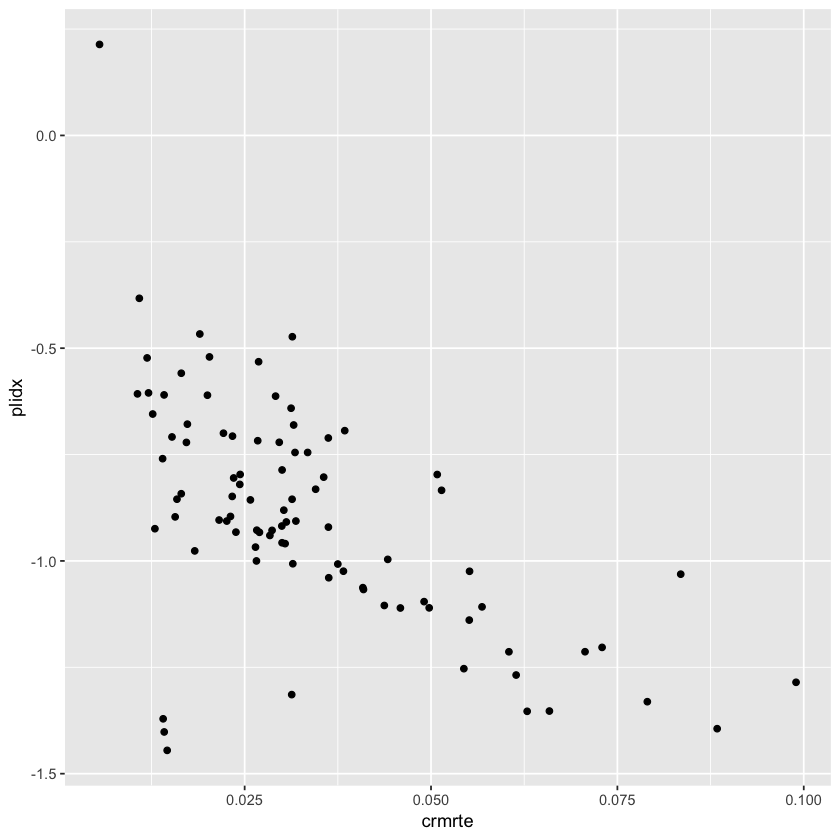

In [233]:
# plot plidx
ggplot(data = mod3_aug, aes(x = crmrte, y = plidx)) + 
  geom_point()

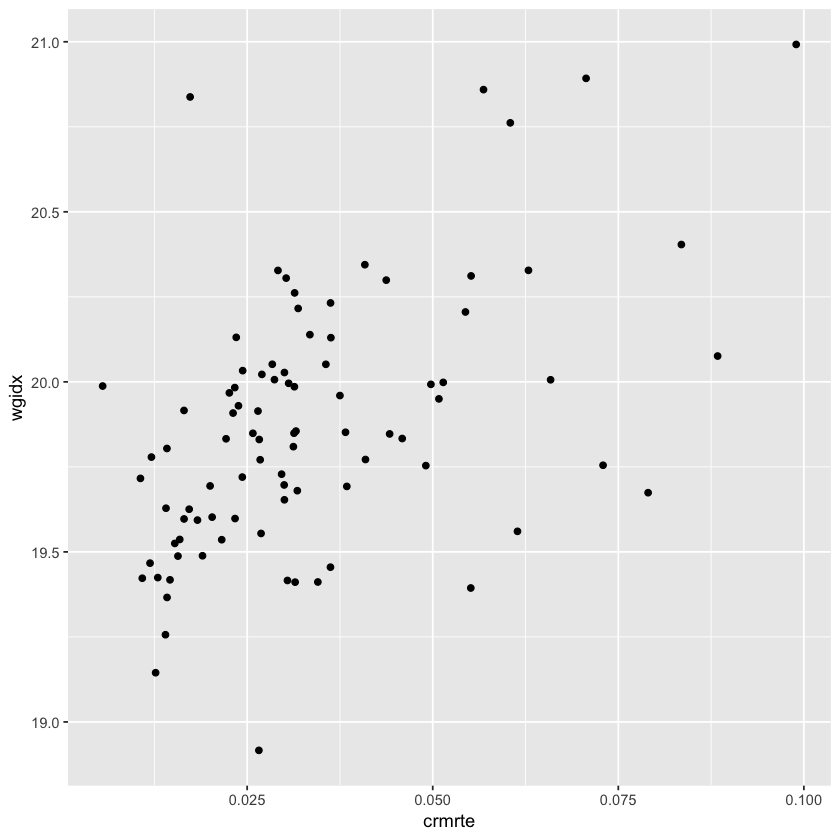

In [234]:
ggplot(data = mod3_aug, aes(x = crmrte, y = wgidx)) + 
  geom_point()